# pyTop - Python Topology Optimization
## 2D plane stress/strain elements

This python code was authored by Narasimha Boddeti, School of Mechanical and Materials Engineering, Washington State University, USA.

This code is intended for educational purposes, please e-mail your comments to the author.

### MIT License

Copyright (c) 2021 Narasimha Boddeti

Permission is hereby granted, free of charge, to any person obtaining a copy 
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

### Python packages

In [24]:
# Python packages
import os
import numpy as np
from scipy import spatial
import vtk
from vtk.util import numpy_support
#import numpy_html
import k3d

# Global variable
verbose = True

# For colors in print output
class style():
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    UNDERLINE = '\033[4m'
    RESET = '\033[0m'

### Mesh Input and Output Class

Supports only Exodus II file format; other mesh formats can be supported indirectly through meshio Python package

In [25]:
class MeshIO:
    # Class for writing and reading Exodus II file format used by Cubit Mesher using VTK    
    
    # init method, similar to a constructor
    def __init__(self, fileName, debugFlag = False):
        self.__FileName = fileName
        self.__DebugFlag = debugFlag
        self.__MBDataSet = None       # vtkMultiBlockDataSet
        self.__PolyData = None        # input/output vtkPolyData
        self.__NodeSetIdDict = {}     # keys - nodeset ids, values - block numbers
        self.__SideSetIdDict = {}
        if os.path.isfile(fileName):
            # Extract the multiblock dataset from the reader
            reader = self.__Read()
            self.__MBDataSet = reader.GetOutput()
            
            # Extract the root polydata
            #geometry = vtk.vtkCompositeDataGeometryFilter() # This combines all the data from all the leaves
            geometry = vtk.vtkGeometryFilter()
            geometry.SetInputData(self.__MBDataSet.GetBlock(0).GetBlock(0)) # Root block and 1st block set
            geometry.Update() # calling this is important for VTK filters
            self.__PolyData = geometry.GetOutput()
            if self.__PolyData == None:
                raise SystemExit("MeshIO: Empty input file!?")
                exit()
            
            self.__NumElements = self.__PolyData.GetNumberOfCells()
            self.__NumNodes = self.__PolyData.GetNumberOfPoints()
            glbNodeIds = self.__PolyData.GetPointData().GetArray("GlobalNodeId")
            self.__GlbToPtIdMap = np.zeros(self.__NumNodes, dtype=int) # "GlobalNodeId" to "Point Id", to be used when reading nodesets
            for i in range(self.__NumNodes):
                self.__GlbToPtIdMap[glbNodeIds.GetValue(i) - 1] = i
                        
            # Extract element and nodal data
            self.__ElemNodesMap = np.zeros(self.__NumElements).astype(list) # accommodates elements with different number of nodes
            self.__NodalCoords = np.zeros([self.__NumNodes, 3]) # 3 columns
            self.__ElementTypes = np.zeros([self.__NumElements, 1]) # Cell types
            for i in range(self.__NumElements):
                cell = self.__PolyData.GetCell(i)
                numPts = cell.GetNumberOfPoints()
                self.__ElementTypes[i] = cell.GetCellType()
                nodeIdsList = []
                for p in range(numPts):
                    ptId = cell.GetPointId(p)
                    nodeIdsList += [ptId]
                    self.__NodalCoords[ptId] = self.__PolyData.GetPoint(ptId)
                self.__ElemNodesMap[i] = nodeIdsList
                
            # Extract node set and side set IDs
            # 8 branches/children for the vtkMultiBlockDataSet; 4 sidesets and 7 nodesets
            self.__NumSideSets = self.__MBDataSet.GetBlock(4).GetNumberOfBlocks()
            self.__NumNodeSets = self.__MBDataSet.GetBlock(7).GetNumberOfBlocks()
            objTypes = [vtk.vtkExodusIIReader.NODE_SET, vtk.vtkExodusIIReader.SIDE_SET]
            dicts = [self.__NodeSetIdDict, self.__SideSetIdDict]
            j = 0
            for objType in objTypes:
                for i in range(reader.GetNumberOfObjects(objType)):
                    dicts[j][reader.GetObjectName(objType, i)] = i
                j += 1
                
            # Summary of the input file parsing
            if verbose:
                print(style.WHITE + "MeshIO: " + style.GREEN + "Read mesh with {} elements and {} nodes".format(self.__NumElements, self.__NumNodes))
                print(style.WHITE + "MeshIO: " + style.GREEN + "The mesh has {} sidesets and {} nodesets".format(self.__NumSideSets, self.__NumNodeSets))
                print(style.WHITE + "MeshIO: " + style.GREEN + "The mesh has sidesets with IDs {}".format(self.__SideSetIdDict.keys()))
                print(style.WHITE + "MeshIO: " + style.GREEN + "The mesh has nodesets with IDs {}".format(self.__NodeSetIdDict.keys()))
            if self.__DebugFlag:
                print(style.MAGENTA + "\nElement nodal id list:")
                print(self.__ElemNodesMap)
                print("\nNodal coordinates:")
                print(self.__NodalCoords)
        else:
            raise SystemExit("MeshIO: Cannot read the file " + style.CYAN + "{}".format(fileName))
            exit()
    
    # Private method - reads the input mesh file and returns a vtkPolyData object
    def __Read(self):
        # Read Exodus Data
        reader = vtk.vtkExodusIIReader()
        reader.SetFileName(self.__FileName)
        reader.UpdateInformation()
        reader.SetTimeStep(0)
        reader.SetAllArrayStatus(vtk.vtkExodusIIReader.ELEM_BLOCK, 1)  # enables all ELEM variables
        reader.SetAllArrayStatus(vtk.vtkExodusIIReader.NODAL, 1)  # enables all NODAL variables
        reader.Update()
        
        # Enable all node and side sets
        objTypes = [vtk.vtkExodusIIReader.NODE_SET, vtk.vtkExodusIIReader.SIDE_SET]
        #glbNodeIdArrName = reader.GetGlobalNodeIdArrayName()
        reader.GenerateGlobalNodeIdArrayOn()
        for objType in objTypes:
            for i in range(reader.GetNumberOfObjects(objType)):
                reader.SetObjectStatus(objType, i, 1)
                #reader.SetObjectArrayStatus(objType, glbNodeIdArrName, 1)
        reader.Update()

        # Extract vtkPolyData through a filter
        #geometry = vtk.vtkCompositeDataGeometryFilter()
        #geometry.SetInputConnection(0, reader.GetOutputPort(0))
        #geometry.Update() # calling this is important for VTK filters
        #polyData = geometry.GetOutput()
       
        return reader

    # Return the number of elements in the mesh
    def GetNumElements(self):
        return self.__NumElements

    # Return the number of nodes in the mesh
    def GetNumNodes(self):
        return self.__NumNodes

    # Extract the node Ids of element "i"
    def GetElementNodalIds(self, i):
        return self.__ElemNodesMap[i]

    # Extract the coordinates of node "i"
    def GetNodalCoordinates(self, i):
        return self.__NodalCoords[i]
    
    def GetElementType(self, i):
        return self.__ElementTypes[i]
    
    # Extract node ids of a node set
    def GetNodeSetNodeIds(self, nodeSetID):
        blockNum = self.__NodeSetIdDict[nodeSetID]
        
        # Extract the relevant block from the stored multiblock dataset
        # Should use vtkExtractBlock?
        geometry = vtk.vtkGeometryFilter()
        # Nodeset child block, guaranteed?
        geometry.SetInputData(self.__MBDataSet.GetBlock(7).GetBlock(blockNum))
        geometry.Update()
        
        # Extract the node ids - hardcoded the array name
        glbNodeIds = geometry.GetOutput().GetPointData().GetArray("GlobalNodeId")
        #numNodes = polyData.GetNumberOfPoints()
        
        # Extract "Point Id" from "Global Node ID"
        ptIds = self.__GlbToPtIdMap[numpy_support.vtk_to_numpy(glbNodeIds) - 1] # The map indices are offset by 1
        
        # Storing with 0 index
        return ptIds
    
    # Extract node ids of each face in a side set
    def GetSideSetNodeIds(self, sideSetID):
        blockNum = self.__SideSetIdDict[sideSetID]
        
        # Extract the relevant block from the stored multiblock dataset
        # Should use vtkExtractBlock?
        geometry = vtk.vtkGeometryFilter()
        # Sideset child block, guaranteed?
        geometry.SetInputData(self.__MBDataSet.GetBlock(4).GetBlock(blockNum))
        geometry.Update()
        polydata = geometry.GetOutput()
        
        # Extract the node ids - hardcoded the array name
        glbNodeIds = geometry.GetOutput().GetPointData().GetArray("GlobalNodeId")
        
        # Extract node Ids and coordinates
        nodeCoords = []
        nodeIds = []
        for i in range(polydata.GetNumberOfCells()):
            cell = polydata.GetCell(i)
            numPts = cell.GetNumberOfPoints()
            nodeIdsList = []
            nodeCrdsList = []
            for p in range(numPts):
                ptId = cell.GetPointId(p)
                glbNodeId = glbNodeIds.GetValue(ptId)
                nodeId = self.__GlbToPtIdMap[glbNodeId - 1]
                nodeIdsList += [nodeId]
                nodeCrdsList += [self.__PolyData.GetPoint(nodeId)]
            nodeIds += [nodeIdsList]
            nodeCoords += [nodeCrdsList]
        
        # Storing with 0 index
        return [nodeIds, nodeCoords]
    
    # Add nodal results to be written to an output file
    def AddNodalResults(self, nodalVals, name):
        # Check input array
        if type(nodalVals) != np.ndarray:
            raise SystemExit("MeshIO: " + style.RED + "Expecting a numpy array")
            exit()
        else:
            vtkArray = numpy_support.numpy_to_vtk(nodalVals)
            vtkArray.SetName(name)
            vtkArray.SetNumberOfTuples(self.__NumNodes)
            ind = self.__PolyData.GetPointData().AddArray(vtkArray) # returns index of the added array
            #ind = self.__MBDataSet.GetBlock(0).GetBlock(0).GetPointData().AddArray(vtkArray)
            if verbose:
                print(style.WHITE + "MeshIO: " + style.GREEN + "Added {} to the output, the index of the added array is {}.".format(name, ind))
        return
    
    # Add nodal results to be written to an output file
    def AddElementalResults(self, elemVals, name):
        # Check input array
        if type(elemVals) != np.ndarray:
            raise SystemExit("MeshIO: " + style.RED + "Expecting a numpy array")
            exit()
        else:
            vtkArray = numpy_support.numpy_to_vtk(elemVals)
            vtkArray.SetName(name)
            vtkArray.SetNumberOfTuples(self.__NumElements)
            ind = self.__PolyData.GetCellData().AddArray(vtkArray)
            if verbose:
                print(style.WHITE + "MeshIO: " + style.GREEN + "Added {} to the output, the index of the added array is {}.".format(name, ind))
        return

    # Write the results to a file for visualization
    def WriteResults(self, outputFileName):
        ## Does not show added arrays
        #vtkWriter = vtk.vtkExodusIIWriter()
        #vtkWriter.SetInputData(self.__MBDataSet)
        #vtkWriter.WriteOutBlockIdArrayOn()
        #vtkWriter.WriteOutGlobalNodeIdArrayOn()
        #vtkWriter.WriteOutGlobalElementIdArrayOn()
        
        # Works but would be useful to use polydata
        #vtkWriter = vtk.vtkXMLUnstructuredGridWriter()
        #vtkWriter.SetInputData(self.__MBDataSet.GetBlock(0).GetBlock(0))
        #vtkWriter.SetFileName(outputFileName)
        #vtkWriter.SetDataModeToBinary()
        ##vtkWriter.SetCompressorTypeToZLib()
        
        ## Not working
        #vtkWriter = vtk.vtkXMLMultiBlockDataWriter()
        #vtkWriter.SetInputData(self.__MBDataSet)
        #vtkWriter.SetFileName(outputFileName)
        #vtkWriter.SetDataModeToBinary()
        
        vtkWriter = vtk.vtkXMLPolyDataWriter()
        vtkWriter.SetInputData(self.__PolyData)
        vtkWriter.SetFileName(outputFileName)
        vtkWriter.SetDataModeToBinary()
        #vtkWriter.SetCompressorTypeToZLib()
        
        vtkWriter.Update()
        if vtkWriter.Write() == 0:
            print("Failed to write :(")
        #elif vtkWriter.Write() == 1:
        #    print("File written :)")
            
        return self.__PolyData
    
    def CalculateLinFilterWeights(self, rmin):
        # Cell based filter
        wgts =[]
        
        # loop over all the elements and gather the element centroids
        elemCents = np.zeros([self.__NumElements, 3])
        for i in range(self.__NumElements):
            nodeIds = self.__ElemNodesMap[i]
            
            # Element centroid
            xC = 0.
            yC = 0.
            zC = 0.
            for nodeId in nodeIds:
                coords = self.__NodalCoords[nodeId]
                xC = xC + coords[0]
                yC = yC + coords[1]
                zC = zC + coords[2]

            elemCents[i] = np.array([xC, yC, zC])/len(nodeIds)
            
        # KDTree for distance computations
        allPtsKDTree = spatial.KDTree(elemCents)
        
        # Calculate weights for each element
        for i in range(self.__NumElements):
            singlePtKDTree = spatial.KDTree([elemCents[i]])
            sdm = allPtsKDTree.sparse_distance_matrix(singlePtKDTree, rmin)
            
            # Should be distance r to the element centroid if rmin - r < 0, else 0
            dists = sdm.toarray().reshape(self.__NumElements,)
            
            # Do rmin -r only r != 0, except the current point
            dists[dists > 0] = rmin - dists[dists > 0]
            dists[i] = rmin
            
            # Normalize and add to the wgts list
            dists = dists/np.sum(dists)
            wgts += [dists]
        
        return wgts

Testing and usage

In [26]:
meshIO = MeshIO("./forInv.g")

MeshIO: Read mesh with 800 elements and 861 nodes
MeshIO: The mesh has 4 sidesets and 5 nodesets
MeshIO: The mesh has sidesets with IDs dict_keys(['xminS', 'xmaxS', 'yminS', 'ymaxS'])
MeshIO: The mesh has nodesets with IDs dict_keys(['xmin', 'xmax', 'ymin', 'ymax', 'fixed'])


In [27]:
meshIO.GetNodalCoordinates(15)

array([0., 7., 0.])

In [28]:
meshIO.GetNodeSetNodeIds('ymax')

array([ 41, 860, 839, 818, 797, 776, 755, 734, 713, 692, 671, 650, 629,
       608, 587, 566, 545, 524, 503, 482, 461, 440, 419, 398, 377, 356,
       335, 314, 293, 272, 251, 230, 209, 188, 167, 146, 125, 104,  83,
        62,  40])

### Gauss Rules

For bars, quads, and hexes

In [29]:
class GaussLegIntRules:
    # Class that stores weights and integration points for Gauss-Legendre quadrature
    
    # Constructor
    def __init__(self, nXi, nEta=-1, nZeta=-1):
        self.w = None     # weights
        self.pts = None   # points
        
        # If only one input, assume 1D
        # If two inputs, 2D nXi x nEta integration rules
        # If three inputs, 3D nXi x nEta x nZeta integration rules
        domType = '1D'
        if nEta > 0 and nZeta == -1:
            domType = '2D'
        if nEta > 0 and nZeta > 0:
            domType = '3D'
        
        (wtsXi, ptsXi) = self.__GaussLegIntRules1D(nXi)
        if domType == '1D': # 1D
            self.w = wtsXi
            self.pts = ptsXi
            return
        elif domType == '2D': # 2D
            (wtsEta, ptsEta) = self.__GaussLegIntRules1D(nEta)
            self.w = np.zeros([nXi*nEta, 1])
            self.pts = np.zeros([nXi*nEta, 2])
            for i in range(nXi):
                for j in range(nEta):
                    ind = nEta*i + j
                    (self.w)[ind] = wtsXi[i]*wtsEta[j]
                    (self.pts)[ind] = [ptsXi[i], ptsEta[j]]
            return
        elif domType == '3D': # 3D
            (wtsEta, ptsEta) = self.__GaussLegIntRules1D(nEta)
            (wtsZeta, ptsZeta) = self.__GaussLegIntRules1D(nZeta)
            self.w = np.zeros(nXi*nEta*nZeta)
            self.pts = np.zeros([nXi*nEta*nZeta, 3])
            for i in range(nXi):
                for j in range(nEta):
                    for k in range(nZeta):
                        ind = nZeta*(nEta*i + j) + k
                        (self.w)[ind] = wtsXi[i]*wtsEta[j]*wtsZeta[k]
                        (self.pts)[ind] = [ptsXi[i], ptsEta[j], ptsZeta[k]]
            return
        
    # Integration rules for 1D
    def __GaussLegIntRules1D(self, n):
        wts = []
        pts = []
        if n == 1: # 1-point integration
            #if domType == '1D': # 1D
            wts = [2]
            pts = [0]
        elif n == 2: # 2-point integration
            wts = [1, 1]
            pts = [-3**-0.5, 3**-0.5]
        elif n == 3: # 3-point integration
            wts = [5/9, 8/9, 5/9]
            pts = [-0.6**0.5, 0, 0.6**0.5]
        else:
            raise SystemExit("GaussRules: Unsupported integration rules")
            exit()
            
        return (wts, pts)
            
    # Accessor for weights
    def GetIntegrationWeights(self):
        return self.w
    
    # Accessor for Gauss integration points
    def GetIntegrationPoints(self):
        return self.pts

Testing and Usage

In [30]:
intRules = GaussLegIntRules(2, 2)
intRules.GetIntegrationPoints()

array([[-0.57735027, -0.57735027],
       [-0.57735027,  0.57735027],
       [ 0.57735027, -0.57735027],
       [ 0.57735027,  0.57735027]])

In [31]:
np.sum(intRules.GetIntegrationWeights())

4.0

In [32]:
intRules.GetIntegrationWeights()

array([[1.],
       [1.],
       [1.],
       [1.]])

### Shape Functions
For bar and quad elements

In [33]:
def ElementShapeFuncsBar(elemNodeCoords, natCoords):
    # Function to calculate the isoparametric shape functions for surface bar elements
    
    # Checks on the input arrays
    if type(elemNodeCoords) != np.ndarray:
        raise SystemExit("ElementShapeFuncsBar: Input error - expecting a numpy array!")
        exit()
         
    if elemNodeCoords.shape[0] != 2 and elemNodeCoords.shape[1] < 2:
        raise SystemExit("ElementShapeFuncsBar: Input error - the numpy array size is not 2 x 2!")
        exit()

    # Extract element nodal coordinates
    x = elemNodeCoords[:, 0] # 1st column
    y = elemNodeCoords[:, 1] # 2nd column
    
    # Extract the natural coordinate
    xi = natCoords
        
    # Shape functions
    N1 = (1 - xi)/2
    N2 = (1 + xi)/2

    # Shape function derivatives w.r.t. natural coordinates
    dN1dxi = -1/2
    dN2dxi =  1/2
    dNdxi = np.array( [dN1dxi, dN2dxi] )

    # Jacobian {dx dy}^T = J d\xi; J is 2x1
    J11 = np.dot(dNdxi, x) # x = N1 x1 + N2 x2 => dx = (dN1/dxi * x1 + dN2/dxi * x2)*d\xi => dx = dNdxi . x
    J21 = np.dot(dNdxi, y) # Same as above, but for dy
    
    # Not quite the determinant, but for consistence call it that
    # This should be half the length of the line connecting the bar element nodes
    detJ = (J11**2 + J21**2)**0.5
    
    # Return a tuple containing the evaluated shapefunction vector and detJ
    return ([N1, N2], detJ)

def ElementShapeFuncsQuad(elemNodeCoords, natCoords):
    # Function to calculate the isoparametric shape functions for surface bar elements
    
    # Checks on the input arrays
    if type(elemNodeCoords) != np.ndarray:
        raise SystemExit("ElementShapeFuncsQuad: Input error - expecting a numpy array!")
        exit()
         
    if elemNodeCoords.shape[0] != 4 and elemNodeCoords.shape[0] < 2:
        raise SystemExit("ElementShapeFuncsQuad: Input error - the numpy array size is not 4 x 2!")
        exit()
    
    if len(natCoords) != 2:
        raise SystemExit("ElementShapeFuncsQuad: Input error - natural coordinates should be a list/array of length 2")
        exit()

    # Extract element nodal coordinates
    x = elemNodeCoords[:, 0] # 1st column
    y = elemNodeCoords[:, 1] # 2nd column
    
    # Extract the natural coordinate
    xi = natCoords[0]
    eta = natCoords[1]
        
    # Shape functions
    N1 = (1 - xi)*(1 - eta)/4
    N2 = (1 + xi)*(1 - eta)/4
    N3 = (1 + xi)*(1 + eta)/4
    N4 = (1 - xi)*(1 + eta)/4
    N = np.array([N1, N2, N3, N4])

    # Shape function derivatives w.r.t. natural coordinates
    dNdxi  = np.array( [ -(1-eta), (1-eta), (1+eta), -(1+eta) ] )/4
    dNdeta = np.array( [  -(1-xi), -(1+xi), (1+xi),   (1-xi)  ] )/4

    # Jacobian {dx dy}^T = J^T {d\xi d\eta}^T; J is 2x2
    J11 = np.dot(dNdxi, x) 
    J12 = np.dot(dNdxi, y)
    J21 = np.dot(dNdeta, x)
    J22 = np.dot(dNdeta, y)
    
    # Determinant of the Jacobian
    detJ = J11*J22 - J21*J12
    if detJ <= 0:
        raise SystemExit("ElementShapeFuncsQuad: detJ is non-positive!")
        exit()
    
    # Shape function derivatives w.r.t. physical coordinates
    dNdx = ( J22*dNdxi - J12*dNdeta)/detJ
    dNdy = (-J21*dNdxi + J11*dNdeta)/detJ
    
    # Return a tuple containing the evaluated shapefunction vector and detJ
    return (N, dNdx, dNdy, detJ)

### Material Classes

In [34]:
from enum import Enum

class StressState(Enum):
    PLANESTRESS = 1
    PLANESTRAIN = 2
    FULL3D = 3

class Material:
    # Base class for constitutive matrix
    
    # Constructor
    def __init__(self, rho):
        self.__Density = rho
        self.__SIMPExponent = 0
        return
    
    def SetSIMPExponent(self, p):
        self.__SIMPExponent = p
        return
        
    def GetSIMPExponent(self):
        return self.__SIMPExponent
    
    def GetDensity(self):
        return self.__Density
        
    def SetDensity(self, rho):
        self._Material__Density = rho
        return #self.ComputeConstMatrix()
    
    def ComputeConstMatrix(self):
        pass # Do nothing
    
class IsotropicStructuralMaterial(Material):
    # Derived class for structural constitutive matrix
    
    def __init__(self, E, v, rho, stressState):
        if stressState != StressState.PLANESTRESS and stressState != StressState.PLANESTRAIN:
            raise SystemExit("IsotropicStructuralMaterial: Stress state {} not implemented".format(stressState))
            exit()
        
        self.__E = E
        self.__v = v
        self.__stressState = stressState
        super().__init__(rho)
        
    def ComputeConstMatrix(self):
        C = None
        
        # SIMP interpolation of the Young's modulus
        E = self.__E*self._Material__Density**self._Material__SIMPExponent
        v = self.__v
        if self.__stressState == StressState.PLANESTRESS:
            prefactor = E/(1 - v**2)
            C = prefactor*np.array( [ [1, v,    0     ],
                                      [v, 1,    0     ],
                                      [0, 0, 0.5*(1-v)] ] )
        elif self.__stressState == StressState.PLANESTRAIN:
            prefactor = E/(1 + v)/(1 + 2*v)
            C = prefactor*np.array( [ [1-v,   v,      0       ],
                                      [  v, 1-v,      0       ],
                                      [  0,   0, 0.5*(1 - 2*v)] ] )
        
        return C

### Element Classes

In [35]:
class Element:
    # Base class for finite elements
    
    # Constructor
    def __init__(self, elemType, nodeIds, nodeCrds, material, props, numIntPoints):
#         if isinstance(elemType, ElementType) == False:
#             raise SystemExit("Element: A valid ElementType required! (e.g., ElementType.QUAD)")
#             exit()
        
        # Checks on the input arrays
        if type(nodeCrds) != np.ndarray:
            raise SystemExit("Element: Input error - expecting a numpy array for nodal coordinates!")
            return
        self.__ElemType = elemType # VTKCellType
        self.__NodeIds = nodeIds
        self.__NodeCrds = nodeCrds
        self.__Material = material
        self.__Properties = props
        self.__NumIntPoints = numIntPoints
        
        if elemType == vtk.VTK_QUAD or elemType == vtk.VTK_TRIANGLE or elemType == vtk.VTK_LINE:
            self.__NumDofsPerNode = 2#len(self._Element__NodeCrds[0])
        else:
            raise SystemExit("Element: Element type {} is not implemented".format(elemType))
            exit()
            
    def SetDensity(self, rho):
        return self.__Material.SetDensity(rho)
    
    def GetDensity(self):
        return self.__Material.GetDensity()
        
    def GetNodeIds(self):
        return self.__NodeIds
    
    def ComputeElementStiffnessAndForceVec(self):
        pass # Do nothing

class SurfElement1D(Element):
    # Element solely for integrationg surface forces
    
    # Constructor
    def __init__(self, elemType, nodeIds, nodeCrds, material, props, numIntPoints):
        # Input checks
        if len(nodeIds) != 2:
            raise SystemExit("SurfElement1D: Surface element with {} nodes is not implemented".format(len(nodeIds)))
            exit()
        
        super().__init__(elemType, nodeIds, nodeCrds, material, props, numIntPoints)
        
        # Thickness and force vector
        if len(self._Element__Properties) != 2:
            raise SystemExit("SurfElement1D: The element properties input should be a list of size 2")
            exit()
            
    def ComputeElementStiffnessAndForceVec(self):
        # Element properties
        h = self._Element__Properties[0] # Thickness
        tracVec = np.array(self._Element__Properties[1])
        tracVec.shape = (self._Element__NumDofsPerNode, 1)
            
        # Gauss-Legendre integration rules
        nXi = self._Element__NumIntPoints
        intRules = GaussLegIntRules(nXi)
        wts = intRules.GetIntegrationWeights()
        pts = intRules.GetIntegrationPoints()
        numIntPoints = len(wts)
        
        # Initialize Ke and fe
        numNodes = len(self._Element__NodeIds)
        totNumDofs = numNodes*self._Element__NumDofsPerNode
        fe = np.zeros([totNumDofs, 1])
        
        # Integration loop
        for i in range(numIntPoints):
            # Get the shape functions and detJ
            (N, detJ) = ElementShapeFuncsBar(self._Element__NodeCrds, pts[i])
            if detJ <= 0:
                raise SystemExit("SurfElement1D: Non-positive detJ!")
                exit()
                
            # Form the Ne matrix
            Ne = np.zeros([self._Element__NumDofsPerNode, totNumDofs])
            for j in range(numNodes):
                Ne[0,     2*j] = N[j]
                Ne[1, 2*j + 1] = N[j]
                
            # Body forces
            fe += h*wts[i]*detJ*Ne.T @ tracVec
            
        return fe
    
class StructuralElement(Element):
    # Element for structural problems
    
    # Constructor
    def __init__(self, elemType, nodeIds, nodeCrds, material, props, numIntPoints):
        if len(nodeIds) != 4:
            raise SystemExit("StructuralElement: Element with {} nodes is not implemented".format(len(nodeIds)))
            exit()
        super().__init__(elemType, nodeIds, nodeCrds, material, props, numIntPoints)
        
    def ComputeElementStiffnessAndForceVec(self):
        # Implement
        numNodes = len(self._Element__NodeIds)
        numDofsPerNode = self._Element__NumDofsPerNode
        totNumDofs = numNodes*numDofsPerNode
        
        # Element properties
        h = self._Element__Properties[0] # Thickness
        bodyForceVec = np.zeros([numDofsPerNode, 1]) # 0 body force
        if len(self._Element__Properties) > 1:
            if len(self._Element__Properties[1]) != numDofsPerNode and type(self._Element__Properties) != list:
                raise SystemExit("StructuralElement: The body force vector should be a list of size {}".format(numDofsPerNode))
                exit()
            bodyForceVec = np.array(self._Element__Properties[1]) #np.array([[0], [0]]) # Body force
            bodyForceVec.shape = (numDofsPerNode, 1)
        
        # Initialize Ke and fe
        Ke = np.zeros([totNumDofs, totNumDofs])
        fe = np.zeros([totNumDofs, 1])
        
        # Gauss-Legendre integration rules
        [nXi, nEta] = self._Element__NumIntPoints
        intRules = GaussLegIntRules(nXi, nEta)
        wts = intRules.GetIntegrationWeights()
        pts = intRules.GetIntegrationPoints()
        numIntPoints = len(wts)
        
        # Integration loop
        vol = 0
        for i in range(numIntPoints):
            # Get the shape functions, their derivatives, detJ etc.
            # Assuming just quads
            (N, dNdx, dNdy, detJ) = ElementShapeFuncsQuad(self._Element__NodeCrds, pts[i])
            if len(dNdx) != numNodes:
                raise SystemExit("StructuralElement: Incorrect shape function derivatives")
                exit()
            
            # Form the Be and Ne matrices
            Ne = np.zeros([numDofsPerNode, totNumDofs])
            Be = np.zeros([3, totNumDofs]) # assuming 2D
            for j in range(numNodes):
                Ne[0,     2*j] = N[j]
                Ne[1, 2*j + 1] = N[j]
                
                Be[0,     2*j] = dNdx[j]
                Be[1, 2*j + 1] = dNdy[j]
                Be[2,     2*j] = dNdy[j]
                Be[2, 2*j + 1] = dNdx[j]
            
            C = self._Element__Material.ComputeConstMatrix()
            Ke += h*wts[i]*detJ*Be.T @ C @ Be
        
            # Body forces
            fe += h*wts[i]*detJ*Ne.T @ bodyForceVec
            
            # Volume
            vol += h*wts[i]*detJ
        
        # Return tuple containing Ke and fe
        self.__Ke = Ke
        self.__Ve = vol[0]
        return (Ke, fe)
    
    def CalcStrainEnergy(self, uElem):
        strEng = 0.5*(uElem.T@self.__Ke@uElem)
        #raise SystemExit("Implement me 1!")
        return strEng
    
    def CalcStrainEnergySensitivity(self, uElem):
        p = self._Element__Material.GetSIMPExponent()
        rho = self._Element__Material.GetDensity()
        
        dStrEng = -0.5*p*rho**(-1)*(uElem.T@self.__Ke@uElem) #why -1 and not p-1

        
        return dStrEng
    
    def CalcDisplacementSensitivity(self, uElem, lamElem):
        p = self._Element__Material.GetSIMPExponent()
        rho = self._Element__Material.GetDensity()
        
        dDispEng = p*rho**(-1)*(lamElem.T@self.__Ke@uElem) #why -1 and not p-1

        return dDispEng
    
    def CalcVolume(self, matFlag = True):
        rho = 1.
        if matFlag == True: # material volume
            rho = self._Element__Material.GetDensity()
        return rho*self.__Ve
    
    def CalcVolumeSensitivity(self):
        dVol = self.__Ve #do we have unit volume??
        #raise SystemExit("Implement me 3!")
        return dVol

In [36]:
mat = IsotropicStructuralMaterial(1, 0.25, 1, StressState.PLANESTRESS)
elem = StructuralElement(vtk.VTK_QUAD, [1, 2, 3, 4], np.array([[-1, -2], [2, -1], [1, 1], [-1, 1]]), mat, [1, [1,1]], [2, 2])
(Ke, fe) = elem.ComputeElementStiffnessAndForceVec()

In [37]:
Ke

array([[ 0.34989367,  0.15433061, -0.2248405 , -0.09816257, -0.19607258,
        -0.15275614,  0.07101941,  0.09658811],
       [ 0.15433061,  0.47850251, -0.03149591,  0.08224624, -0.15275614,
        -0.32336936,  0.02992144, -0.23737939],
       [-0.2248405 , -0.03149591,  0.53726075, -0.15275614, -0.00589113,
         0.02913421, -0.30652912,  0.15511784],
       [-0.09816257,  0.08224624, -0.15275614,  0.40996397,  0.09580087,
        -0.31494596,  0.15511784, -0.17726425],
       [-0.19607258, -0.15275614, -0.00589113,  0.09580087,  0.54217003,
         0.15629869, -0.34020632, -0.09934343],
       [-0.15275614, -0.32336936,  0.02913421, -0.31494596,  0.15629869,
         0.67241894, -0.03267676, -0.03410362],
       [ 0.07101941,  0.02992144, -0.30652912,  0.15511784, -0.34020632,
        -0.03267676,  0.57571603, -0.15236252],
       [ 0.09658811, -0.23737939,  0.15511784, -0.17726425, -0.09934343,
        -0.03410362, -0.15236252,  0.44874726]])

In [38]:
fe

array([[1.83333333],
       [1.83333333],
       [1.66666667],
       [1.66666667],
       [1.41666667],
       [1.41666667],
       [1.58333333],
       [1.58333333]])

In [39]:
elem = SurfElement1D(vtk.VTK_LINE, [1, 2], np.array([[0, 0], [1, 1]]), None, [1, [1,0.5]], 2)
fe = elem.ComputeElementStiffnessAndForceVec()
fe

array([[0.70710678],
       [0.35355339],
       [0.70710678],
       [0.35355339]])

### FE Solver Class

In [40]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
import copy

class FESolver():
    # Solver class
    
    # Constructor
    def __init__(self, meshFileName, elemProps, elemMatls, DirichletBCs, NeumannBCs = [[],[]], PointLoads = [[],[]], SpringLoads = [[],[]], outnode=[[],[]], isTopOpt = False):
        # Checks on the input arrays
        if type(elemProps) != list:
            raise SystemExit("FESolver: Input error - expecting a list for element properties!")
            exit()
        
        if type(elemMatls) != list:
            raise SystemExit("FESolver: Input error - expecting a list of Material objects!")
            exit()
        
        # DiricheltBCs - List of node set indices, direction and prescribed value
        if type(DirichletBCs) != list:
            raise SystemExit("FESolver: Input error - Dirichlet BCs should contain a list of node set Ids, list of directions (0 for x, 1 for y, 2 for z) \n and list of prescribed value in a list or tuple form!")
            exit()
        if len(DirichletBCs) != 3 and type(DirichletBCs[0]) != list and type(DirichletBCs[1]) != list and type(DirichletBCs[2]) != list:
            raise SystemExit("FESolver: Input error - Dirichlet BCs should contain a list of node set Ids, list of directions (0 for x, 1 for y, 2 for z) \n and list of prescribed value in a list or tuple form!")
            exit()
        
        # NeumannBCs - List of side set index, traction vector
        if type(NeumannBCs) != list:
            raise SystemExit("FESolver: Input error - Neumann BCs should contain a list of side set Ids and the vector in a list or tuple form!")
            exit()
        if NeumannBCs != [[],[]]:
            if len(NeumannBCs) != 2 and type(NeumannBCs[0]) != list and type(NeumannBCs[1]) != list:
                raise SystemExit("FESolver: Input error - Neumann BCs should contain a list of side set Ids and the vector in a list or tuple form!")
                exit()
        
        # PointLoads - List of node ids, force vector
        if PointLoads != [[],[]]:
            if len(PointLoads) != 2 and type(PointLoads[0]) != int and type(PointLoads[1]) != list:
                raise SystemExit("FESolver: Input error - Point loads should contain a list of node Ids and the vector in a list or tuple form!")
                exit() 
        
        # SpringLoads - List of node ids, spring constants
        if SpringLoads != [[],[]]:
            if len(SpringLoads) != 2 and type(PointLoads[0]) != int and type(SpringLoads[1]) != list:
                raise SystemExit("FESolver: Input error - Spring Loads should contain a list of node Ids and the vector in a list or tuple form!")
                exit() 
        
        self.__MeshIO = MeshIO(meshFileName)
        self.__ElemProps = elemProps
        self.__ElemMatls = elemMatls
        self.__DirichletBCs = DirichletBCs
        self.__NeumannBCs = NeumannBCs
        self.__PointLoads = PointLoads
        self.__SpringLoads = SpringLoads
        self.__outnode = outnode
        self.__OutFileName = meshFileName[:-1] + "vtp" # Assuming the input ends with .g, replace the last character with vtu
        
        # Create elements
        self.__NumElems = self.__MeshIO.GetNumElements()
        self.__NumNodes = self.__MeshIO.GetNumNodes()
        self.__Elements = self.__CreateElements(self.__NumElems, self.__NumNodes, isTopOpt)
        self.__SurfElements = self.__CreateSurfElements()
        self.__NumDofsPerNode = 2 # Hardcoded for now
        
        if verbose:
            print(style.WHITE + "FESolver: " + style.GREEN + "Finished setting up the FE model with {} elements and {} surface elements".format(self.__NumElems, len(self.__SurfElements)))
    
    def __CreateElements(self, numElems, numNodes, isTopOpt):        
        # Check if the material properties are homogeneous
        matHomo = False
        if len(self.__ElemMatls) == 1:
            matHomo = True
        elif len(self.__ElemMatls) != numElems:
            raise SystemExit("FESolver: Input error - length of input materials list should be equal to number of cells in the mesh!")
            exit()
            
        # Check if the element properties are homogeneous
        propHomo = False
        if len(self.__ElemProps) == 1:
            propHomo = True
        elif len(self.__ElemMatls) != numElems:
            raise SystemExit("FESolver: Input error - length of input element properties array should be equal to number of cells in the mesh!")
            exit()
        
        # Create a StructuralElement object for each cell in the mesh
        elems = [] # list of elements
        for i in range(numElems):
            nodIds = self.__MeshIO.GetElementNodalIds(i)
            nodCrds = np.zeros([len(nodIds), 3])
            for j in range(len(nodIds)):
                nodCrds[j] = self.__MeshIO.GetNodalCoordinates(nodIds[j])
                
            #print(nodIds)
            #print(nodCrds)
            
            props = self.__ElemProps
            if propHomo == False:
                props = self.__ElemProps[i]
            mat = self.__ElemMatls[0]
            if matHomo == False:
                mat = self.__ElemMatls[i]
                
            if isTopOpt == True:
                mat = copy.deepcopy(mat)
            
            # Create and concatentate the element to list of elements
            elmTyp = self.__MeshIO.GetElementType(i)
            elems += [StructuralElement(elmTyp, nodIds, nodCrds, mat, props, [2, 2])] # assuming 2x2 integration rules
        
        return elems
    
    def __CreateSurfElements(self):
        # Create surface elements to faciliate traction integration
        surfElems = []
        for i in range(len(self.__NeumannBCs[0])):
            [nIds, nCrds] = self.__MeshIO.GetSideSetNodeIds(self.__NeumannBCs[0][i])
            props = [1, self.__NeumannBCs[1][i]] # Hardcode thickness
            for j in range(len(nIds)):
                # Hardcode element type
                surfElems += [SurfElement1D(vtk.VTK_LINE, nIds[j], np.array(nCrds[j]), None, props, 2)]
            
        return surfElems
    
    def SetDensities(self, rhos):
        i = 0
        for elem in self.__Elements:
            elem.SetDensity(rhos[i])
            i += 1
            
    def GetDensities(self):
        i = 0
        rhos = np.zeros(self.__NumElems)
        for elem in self.__Elements:
            rhos[i] = elem.GetDensity()
            i += 1
            
        return rhos
            
    def GetNumElements(self):
        return self.__NumElems
    
    # Assemble the global stiffness matrix Kg and force vector fg
    def GlobalAssembly(self):
        numDofs = self.__NumDofsPerNode*self.__NumNodes
        K = np.zeros([numDofs, numDofs])
        f = np.zeros([numDofs, 1])
        #print('checkingloads', self.__PointLoads[1][0][0])
              
        # Evaluate element stiffness matrices and force vectors
        for i in range(self.__NumElems):
            elem = self.__Elements[i]
            (Ke, fe) = elem.ComputeElementStiffnessAndForceVec()
            
            nodIds = np.array(self.__MeshIO.GetElementNodalIds(i))
            dofIndices = np.empty((self.__NumDofsPerNode*nodIds.size,), dtype=int)
            for j in range(self.__NumDofsPerNode):
                dofIndices[j::self.__NumDofsPerNode] = self.__NumDofsPerNode*nodIds + j
            #print(dofIndices)
            # Add to K and f at appropriate locations
            K[np.ix_(dofIndices, dofIndices)] += Ke
            f[dofIndices] += fe
            
        # Add force due to tractions
        for surfElem in self.__SurfElements:
            fe = surfElem.ComputeElementStiffnessAndForceVec()
            
            nodIds = np.array(surfElem.GetNodeIds())
            dofIndices = np.empty((self.__NumDofsPerNode*nodIds.size,), dtype=int)
            for j in range(self.__NumDofsPerNode):
                dofIndices[j::self.__NumDofsPerNode] = self.__NumDofsPerNode*nodIds + j
                
            f[dofIndices] += fe
        
        # Point loads
        for i in range(len(self.__PointLoads[0])):
            nodId = self.__PointLoads[0][i]
            for j in range(self.__NumDofsPerNode):
                f[self.__NumDofsPerNode*nodId + j] += self.__PointLoads[1][i][j]
                #f[673*2 + 1] = -1.
                
        #something got messed up and had to hard code this
        #f[self.__PointLoads[0]*2] += self.__PointLoads[1][0][0]
        #print("Norm of the unmodified force vector: {}".format(np.linalg.norm(f)))
        
        #print('stiffness pretest',K[self.__SpringLoads[0][1]*2,self.__SpringLoads[0][1]*2])
        
        #Modify Stiffness Vector
        for i in range(len(self.__SpringLoads[0])):  #this gives length of how many springs are inputted. If 2 springs then length will be 2.
            nodId = self.__SpringLoads[0][i]  #this gives what node you are trying to edit
            for j in range(self.__NumDofsPerNode):
                K[self.__NumDofsPerNode*nodId + j, self.__NumDofsPerNode*nodId + j] += self.__SpringLoads[1][i][j] #this edits the global stiffness variable so 1 accesses the spring constant vectors, i accesses the set of spring constants for a nopde and j accesses the spring constants along a dof.
        
        #print('stiffness posttest', K[self.__SpringLoads[0][1]*2,self.__SpringLoads[0][1]*2])
        
        #make the z vector for the adjoint problem        
        z = np.zeros([numDofs,1]) # initialize z vector
        for i in range(len(self.__outnode[0])):
            nodId = self.__outnode[0][i]
            for j in range(self.__NumDofsPerNode):
                z[self.__NumDofsPerNode*nodId + j] += self.__outnode[1][i][j]
        
        if (len(self.__outnode[0]) > 0):
            z[self.__outnode[0][0]*2] = self.__outnode[1][0][0]
            self.__z = z
            #print('z check', z[self.__outnode[0][0]*2])

        # Modify the force vector and the z vector (to get the adjoint problem)
        rowInds = []
        dofVals = []
        for k in range(len(self.__DirichletBCs[0])):
            nsId = self.__DirichletBCs[0][k]
            dofs = self.__DirichletBCs[1][k] # Should be 0, 1 or 2
            vals = self.__DirichletBCs[2][k] # Should be the same size as dofs
            if len(vals) != len(dofs):
                raise SystemExit("FESolver: Input error - check the Dirichlet BCs")
                exit()
            
            # Get the nodes from the node set
            nodeIds = self.__MeshIO.GetNodeSetNodeIds(nsId)
            #print("Node set Ids for node set id \"{}\": {}".format(nsId, nodeIds))
            for nId in nodeIds:
                for d in range(len(dofs)):
                    if type(d) != int or d > 2 or d < 0:
                        raise SystemExit("FESolver: Input error - check the Dirichlet BCs")
                        exit()

                    dofInd = 2*nId + dofs[d]
                    rowInds += [dofInd]
                    dofVals += [vals[d]]
                    #print("{} = {} - {} - {}".format(k, nId, dofInd, vals[d]))
                    Kcol = K[:, dofInd]
                    Kcol.shape = (numDofs, 1)
                    f -= Kcol*vals[d]
                    z -= Kcol*vals[d]
                    
        # Store the prescribed DoFs and the values
        self.__PrescDofs = rowInds
        self.__PrescVals = dofVals
        
        # Delete rows and columns that are not needed
        self.__Kg = np.delete(np.delete(K, rowInds, 0), rowInds, 1)
        self.__fg = np.delete(f, rowInds, 0)
        self.__zg = np.delete(z, rowInds,0)
        #print('check modified stiffness',np.linalg.norm(self.__Kg))
        #print('check modified force',np.linalg.norm(self.__fg))
        #print('check modified z',np.linalg.norm(self.__zg))
        #print(self.__Kg)
        
        if verbose:
            print(style.WHITE + "FESolver: " + style.GREEN + "Finished global assembly")  
        return
            
    # Solve the linear system formed by the Kg and fg and the adjoint problem
    def Solve(self):
        K = csc_matrix(self.__Kg)
        f = csc_matrix(self.__fg)
        u = spsolve(K, f)
        
        # All displacements and all lambda values
        numDofs = self.__NumDofsPerNode*self.__NumNodes
        uFull = np.zeros(numDofs)
        freeDofs = np.delete(np.arange(numDofs), self.__PrescDofs, 0)
        uFull[self.__PrescDofs] = self.__PrescVals
        uFull[freeDofs] = u
        
        self.__uFull = uFull
        
        if len(self.__outnode[0]) > 0:
            z= self.__zg
            lam = spsolve(K, z)
            #result  = a.any(np.where(f == 1))
            #print('check f is still populated',result)
            lamFull = np.zeros(numDofs)
            lamFull[self.__PrescDofs] = self.__PrescVals
            lamFull[freeDofs] = lam
            self.__lamFull = lamFull
        
        if verbose:
            print(style.WHITE + "FESolver: " + style.GREEN + "Solve completed")
        return uFull
    
    def CalculateLinFilterWeights(self, rmin):
        return self.__MeshIO.CalculateLinFilterWeights(rmin)
    
    def CalcStrainEnergy(self):
        # Calculate strain energy
        sStrEng = np.zeros(self.__NumElems) # Should probably store these with the elements
        i = 0
        for elem in self.__Elements:
            nodIds = np.array(self.__MeshIO.GetElementNodalIds(i))
            dofIndices = np.empty((self.__NumDofsPerNode*nodIds.size,), dtype=int)
            for j in range(self.__NumDofsPerNode):
                dofIndices[j::self.__NumDofsPerNode] = self.__NumDofsPerNode*nodIds + j
            uElem = self.__uFull[dofIndices]
            sStrEng[i] = elem.CalcStrainEnergy(uElem)
            #print(strEng)
            i += 1
            
        totStrEng = np.sum(sStrEng)
        if verbose:
            print(style.WHITE + "FESolver: " + style.GREEN + "Total strain energy is: {:.8G}".format(totStrEng))

        return (totStrEng, sStrEng)

    
    def CalcStrainEnergySens(self):
        # Calculate strain energy sensitivities
        dStrEng = np.zeros(self.__NumElems)
        i = 0
        for elem in self.__Elements:
            nodIds = np.array(self.__MeshIO.GetElementNodalIds(i))
            dofIndices = np.empty((self.__NumDofsPerNode*nodIds.size,), dtype=int)
            for j in range(self.__NumDofsPerNode):
                dofIndices[j::self.__NumDofsPerNode] = self.__NumDofsPerNode*nodIds + j
            uElem = self.__uFull[dofIndices]
            dStrEng[i] = elem.CalcStrainEnergySensitivity(uElem)
            #print(strEng[i])
            i += 1
            
        return dStrEng
    
    
    #calculate uout - displacement objective
    def CalcDisplacementOut(self):
        
        #print(self.__uFull)
        disp = -self.__uFull@self.__z
        #print(disp)

        
        if verbose:
            print(style.WHITE + "FESolver: " + style.GREEN + "Output displacement is: {:.8G}".format(uout))

        return disp

     
    #calculate displacement sensitivities - 
    def CalcDisplacementSens(self):

        dDispEng = np.zeros(self.__NumElems)
        i = 0
        for elem in self.__Elements:
            nodIds = np.array(self.__MeshIO.GetElementNodalIds(i))
            dofIndices = np.empty((self.__NumDofsPerNode*nodIds.size,), dtype=int)
            for j in range(self.__NumDofsPerNode):
                dofIndices[j::self.__NumDofsPerNode] = self.__NumDofsPerNode*nodIds + j
            uElem = self.__uFull[dofIndices]
            lamElem = self.__lamFull[dofIndices]
            dDispEng[i] = elem.CalcDisplacementSensitivity(uElem, lamElem)
            #print(strEng[i])
            i += 1
            
        return dDispEng
    
    
    def CalcVolume(self):
        totVol = 0
        i = 0
        for elem in self.__Elements:
            totVol += elem.CalcVolume()
            i += 1
            
        return totVol
    
    def CalcVolumeSens(self):
        dVol = np.zeros(self.__NumElems)
        i = 0
        for elem in self.__Elements:
            dVol[i] = elem.CalcVolumeSensitivity()
            i += 1
            
        return dVol
        
    def PostProcess(self, it=-1):
        # Write the strain energies
        (totStrEng, strEng) = self.CalcStrainEnergy()
        if verbose:
            print(style.WHITE + "FESolver: " + style.GREEN + "Total strain energy is: {:.8G}".format(totStrEng))
        
        # Write the strain energies
        self.__MeshIO.AddElementalResults(strEng, "Strain Energy")
        self.__MeshIO.AddElementalResults(self.GetDensities(), "Density")
        
        # Write the displacements/densities and save
        uFull = self.__uFull.reshape(self.__NumNodes, self.__NumDofsPerNode)
        
        # Add 0 z-displacements for 2D problems
        if self.__NumDofsPerNode == 2:
            # Add a column with zeros
            uFull = np.concatenate((uFull, np.zeros([self.__NumNodes, 1])), axis=1)
            
        self.__MeshIO.AddNodalResults(uFull, "Displacement")
        self.__MeshIO.AddNodalResults(uFull[:,0], "Ux")
        self.__MeshIO.AddNodalResults(uFull[:,1], "Uy")
        if it == -1:
            pd = self.__MeshIO.WriteResults(self.__OutFileName)
        else:
            folderPath = self.__OutFileName[:-4] # Assuming .g or .e extensions
            fileName = folderPath.split('/')[-1]
            pd = self.__MeshIO.WriteResults(folderPath + '/' + fileName + "_{:0>3}.vtp".format(it))
        
        if verbose:
            print(style.WHITE + "FESolver: " + style.GREEN + "Post-processing done and results written to the file {}!".format(self.__OutFileName))
        return (totStrEng, pd)
    
    
    #post Processing for Displacement
    def PostProcess_disp(self, it=-1):
        # Write the strain energies
        uout = self.CalcDisplacementOut()
        #print(uout)
        if verbose:
            print(style.WHITE + "FESolver: " + style.GREEN + "Nodal Displacement is: {:.8G}".format(uout))
        
        # Write the strain energies
        self.__MeshIO.AddElementalResults(uout, "Displacement")
        self.__MeshIO.AddElementalResults(self.GetDensities(), "Density")
        
        # Write the displacements/densities and save
        uFull = self.__uFull.reshape(self.__NumNodes, self.__NumDofsPerNode)
        
        # Add 0 z-displacements for 2D problems
        if self.__NumDofsPerNode == 2:
            # Add a column with zeros
            uFull = np.concatenate((uFull, np.zeros([self.__NumNodes, 1])), axis=1)
            
        self.__MeshIO.AddNodalResults(uFull, "Displacement")
        self.__MeshIO.AddNodalResults(uFull[:,0], "Ux")
        self.__MeshIO.AddNodalResults(uFull[:,1], "Uy")
        if it == -1:
            pd = self.__MeshIO.WriteResults(self.__OutFileName)
        else:
            folderPath = self.__OutFileName[:-4] # Assuming .g or .e extensions
            fileName = folderPath.split('/')[-1]
            pd = self.__MeshIO.WriteResults(folderPath + '/' + fileName + "_{:0>3}.vtp".format(it))
        
        if verbose:
            print(style.WHITE + "FESolver: " + style.GREEN + "Post-processing done and results written to the file {}!".format(self.__OutFileName))
        return (uout, pd)

### FEA Testing

In [20]:
verbose = True
q = -0.1
L = 20.
E = 10000
I = 1/12
mat = IsotropicStructuralMaterial(E, 0.3, 1, StressState.PLANESTRESS)
DBCs = [['xmin'],   # node set identifiers
        [[0, 1]],      # Dofs to fix: 0 - X, 1 - Y, 2 - Z
        [[0, 0]]]    # Prescribed values
NBCs = [['ymax'], [[0, q]]]
fesolver = FESolver("./forInv.g", [1], [mat], DBCs, NBCs)
fesolver.GlobalAssembly()
u = fesolver.Solve();
fesolver.PostProcess()
print("Max deflection from FE = {:.4f}".format(np.min(u)))
print("Tip deflection from Euler-Bernoulli beam theory = {:.4f}".format((q*L**4)/(8*E*I)))

MeshIO: Read mesh with 800 elements and 861 nodes
MeshIO: The mesh has 4 sidesets and 5 nodesets
MeshIO: The mesh has sidesets with IDs dict_keys(['xminS', 'xmaxS', 'yminS', 'ymaxS'])
MeshIO: The mesh has nodesets with IDs dict_keys(['xmin', 'xmax', 'ymin', 'ymax', 'fixed'])


KeyError: 'ymax'

In [19]:
verbose = True
E = 1
mat = IsotropicStructuralMaterial(E, 0.3, 1, StressState.PLANESTRESS)
DBCs = [['ymax','fixed'],        # list of node set identifiers
        [[1],[0,1]],        # list of dofs to fix: 0 - X, 1 - Y, 2 - Z
        [[0],[0,0]]]        # list of prescribed values
NBCs = [[],              # list of side set identifiers
        []]              # list of prescribed traction vectors
PtLoads = [[41],        # list of nodal ids - 673 is the lower right corner, 682 is the right mid-node, 692 is the upper right corner
           [[1, 0]]]    # list of prescribed point force vectors at each node
SpringLoads = [[41, 860],    # list of nodal ids for the spring loads
               [[0.1,0],[0.1,0]]] #list of spring constants at the oerscribed node
outnode = [[860],          #insert node id of desired uout
          [[-1,0]]]
fesolver = FESolver("./forInv.g", [1], [mat], DBCs, NBCs, PtLoads)
fesolver.GlobalAssembly()
u = fesolver.Solve();
print(u[860*1])
(eng, pd) = fesolver.PostProcess()
print("Max deflection from FE = {:.4f}".format(np.min(u)))

MeshIO: Read mesh with 800 elements and 861 nodes
MeshIO: The mesh has 4 sidesets and 5 nodesets
MeshIO: The mesh has sidesets with IDs dict_keys(['xminS', 'xmaxS', 'yminS', 'ymaxS'])
MeshIO: The mesh has nodesets with IDs dict_keys(['xmin', 'xmax', 'ymin', 'ymax', 'fixed'])
FESolver: Finished setting up the FE model with 800 elements and 0 surface elements
Norm of the unmodified force vector: 1.0
Node set Ids for node set id "ymax": [ 41 860 839 818 797 776 755 734 713 692 671 650 629 608 587 566 545 524
 503 482 461 440 419 398 377 356 335 314 293 272 251 230 209 188 167 146
 125 104  83  62  40]
Node set Ids for node set id "fixed": [ 41 860 839 818 797 776 755 734 713 692 671 650 629 608 587 566 545 524
 503 482 461 440 419 398 377 356 335 314 293 272 251 230 209 188 167 146
 125 104  83  62  40   2   7   5   1]
check modified stiffness 87.47082120830196
check modified force 0.0
check modified z 0.0
FESolver: Finished global assembly
FESolver: Solve completed
0.0
FESolver: Total st

In [20]:
def PlotResult(polydata, arrName):
    (x1, x2, y1, y2, z1, z2) = polydata.GetBounds()
    x0 = 0.5*(x1+x2)
    y0 = 0.5*(y1+y2)
    
    arr = numpy_support.vtk_to_numpy(polydata.GetPointData().GetArray(arrName))
    arrMin = np.min(arr)
    arrMax = np.max(arr)    

    plot = k3d.plot()
    #plot.menu_visibility = False
    #plot.camera_no_rotate = True
    plot.grid_visible = False
    plot.camera_pan_speed = 2
    mesh = k3d.vtk_poly_data(polydata, color_attribute=(arrName, arrMin, arrMax),color_map=k3d.paraview_color_maps.Plasma_matplotlib)#,model_matrix=model_matrix)
    plot += mesh
    plot.display()
    plot.camera = [x0, y0, 10/1.8, x0, y0, 0, 0, 1, 0]
    
PlotResult(pd, 'Ux')
PlotResult(pd, 'Uy')

Output()

Output()

In [21]:
verbose = True
P = -10.
L = 20.
E = 10000
I = 1/12
mat = IsotropicStructuralMaterial(E, 0.3, 1, StressState.PLANESTRESS)
DBCs = [['xmin'],   # node set identifiers
        [[0, 1]],      # Dofs to fix: 0 - X, 1 - Y, 2 - Z
        [[0, 0]]]    # Prescribed values
#NBCs = [['xmax'], [[0, 0]]]
PtLoads = [[2205], [[0, P]]]
fesolver = FESolver("./beam2D.g", [1], [mat], DBCs, PointLoads = PtLoads)
fesolver.GlobalAssembly()
u = fesolver.Solve();
(eng, pd) = fesolver.PostProcess()
print("Max deflection from FE = {:.4f}".format(np.min(u)))
print("Tip deflection from Euler-Bernoulli beam theory = {:.4f}".format((P*L**3)/(3*E*I)))

MeshIO: Read mesh with 640 elements and 693 nodes
MeshIO: The mesh has 4 sidesets and 5 nodesets
MeshIO: The mesh has sidesets with IDs dict_keys(['xmin', 'xmax', 'ymin', 'ymax'])
MeshIO: The mesh has nodesets with IDs dict_keys(['xmin', 'xmax', 'ymin', 'ymax', 'corner'])
FESolver: Finished setting up the FE model with 640 elements and 0 surface elements


IndexError: index 4410 is out of bounds for axis 0 with size 1386

In [22]:
def PlotResult(polydata, arrName):
    (x1, x2, y1, y2, z1, z2) = polydata.GetBounds()
    x0 = 0.5*(x1+x2)
    y0 = 0.5*(y1+y2)
    
    arr = numpy_support.vtk_to_numpy(polydata.GetPointData().GetArray(arrName))
    arrMin = np.min(arr)
    arrMax = np.max(arr)    

    plot = k3d.plot()
    #plot.menu_visibility = False
    #plot.camera_no_rotate = True
    plot.grid_visible = False
    plot.camera_pan_speed = 2
    mesh = k3d.vtk_poly_data(polydata, color_attribute=(arrName, arrMin, arrMax),color_map=k3d.paraview_color_maps.Plasma_matplotlib)#,model_matrix=model_matrix)
    plot += mesh
    plot.display()
    plot.camera = [x0, y0, 10/1.8, x0, y0, 0, 0, 1, 0]
    
PlotResult(pd, 'Ux')
PlotResult(pd, 'Uy')

Output()

Output()

### Optimality Criteria Method

In [41]:
# OC Update
def OCUpdate(rho, prescMatVol, objGrad, constGrad, elemVols, wgts, filterType, betaP = -1, etaP = -1):
    #print(objGrad)
    l1 = 0.
    l2 = 10.**5
    move = 0.2
    eta = 0.5 # Not to be confused with the eta parameter of the projection filter
    volConst = 0.
    ones = np.ones_like(rho)
    rhomin = 1.e-3 * ones
    rhoNew = rho
    while (l2-l1) > 1.e-4:
        lmid = (l2+l1)*0.5
        rhoBk = rho * ((-objGrad/constGrad)/lmid)**eta
        rhoNew = np.maximum(rhomin, np.maximum(rho - move, np.minimum(ones, np.minimum(rho + move, rhoBk))))

        # Update interval
        rhoFilt = rhoNew
        if filterType == 'Density' and len(wgts) > 0:
            rhoFilt = wgts @ rhoFilt
            if betaP > 0:
                rhoFilt = 0.001 + 0.999*(np.tanh(betaP*etaP) + np.tanh(betaP*(rhoFilt - etaP)))/(np.tanh(betaP*etaP) + np.tanh(betaP*(1 - etaP)))
        volConst = rhoFilt.T @ elemVols - prescMatVol
        if volConst > 0:
            l1 = lmid
        else:
            l2 = lmid
    #print("{}, {}, {}, {}".format(l1, l2, lmid, np.sum(rhoNew)))
    return (rhoNew, volConst, lmid)

import time
from ipywidgets import IntSlider, interact
# Plotter class
class k3dPlotter():
    def __init__(self):
        self.__Plot = k3d.plot()
        #self.__Plot.menu_visibility = False
        self.__Plot.camera_no_rotate = True
        self.__Plot.camera_pan_speed = 2
        self.__Plot.grid_visible = False
        self.__Plot.camera_auto_fit = False
        self.__Plot.background_color = 0xF3FFFF
        
        return
    
    def Update(self, polydata, it):
        self.__Mesh = k3d.vtk_poly_data(polydata, cell_color_attribute=('Density', 0.001, 1), color_map=k3d.paraview_color_maps.X_Ray)
        if len(self.__Plot.objects) == 0:
            bnds = polydata.GetBounds()
            x0 = 0.5*(bnds[0] + bnds[1])
            y0 = 0.5*(bnds[2] + bnds[3])
            zC = max(bnds[1] - bnds[0], bnds[3] - bnds[2])/1.8 # Assuming POV is 60 deg
            #self.__Mesh = k3d.vtk_poly_data(polydata, cell_color_attribute=('Density', 0.001, 1), color_map=k3d.paraview_color_maps.X_Ray)
            self.__PrevMesh = self.__Mesh
            self.__Plot += self.__Mesh
            self.__Text = k3d.text2d(r'Iteration = {}'.format(it), position=[0, 0], color=0x0000ff, size=1)
            self.__Plot += self.__Text
            self.__Plot.display()
            self.__Plot.camera = [x0, y0, zC, x0, y0, 0, 0, 1, 0]
            #time.sleep(0.1)
        else:
            self.__Text.text = r'Iteration = {}'.format(it)
            #self.__Mesh.attribute = polydata.GetCellData().GetArray('Density')
            self.__Plot += self.__Mesh
            #self.__Plot -= self.__PrevMesh
            self.__PrevMesh = self.__Mesh
            #self.__Plot;
        
        return
        
def TopOpt_OC(meshFileName, elemProps, elemMatls, DirichletBCs, NeumannBCs, PointLoads, SpringLoads, outnode, volFrac, rmin=-1, filterType = 'Sensitivity', projFlag = False, maxIts = 200):
    fesolver = FESolver(meshFileName, elemProps, elemMatls, DirichletBCs, NeumannBCs, PointLoads, SpringLoads, outnode, True)
    
    # Create a directory to save results
    if os.path.isdir(meshFileName[:-2]) == False:
        os.mkdir(meshFileName[:-2])
    
    # Linear filter weights
    wgts = []
    if rmin > 0:
        wgts = np.array(fesolver.CalculateLinFilterWeights(rmin))
        
    # Plot handle
    plotter = k3dPlotter()
    #interact(plotter.MoveToIteration, it = IntSlider(min=0, max=100, step=1, value=0))
    
    # Projection filter parameters
    beta = -1
    if projFlag:
        beta = 1.
    eta = 0.5
    
    # Initialize some variables
    ones = np.ones([fesolver.GetNumElements(), ])
    rho = volFrac*ones
    objHist = []
    constHist = []
    elemVols = []
    dVol = []
    dVolUnmod = []
    prescMatVol = 0
    maxRhoChange = 2.
    betaIt = 0
    
    # Optmization loop
    for it in range(maxIts):
        # Store the old design
        rho_old = rho
        
        # Density filter
        rhoFilt = rho # Will be modified only if filterType = 'Density' and rmin > 0
        if rmin > 0 and filterType == 'Density':
            # Apply linear filter
            rhoFilt = wgts @ rhoFilt
            # Apply projection filter
            if projFlag:
                # Keeps the projected values between 0.001 and 1
                rhoFilt = 0.001 + 0.999*(np.tanh(beta*eta) + np.tanh(beta*(rhoFilt - eta)))/(np.tanh(beta*eta) + np.tanh(beta*(1 - eta)))
                dRhoProj = 0.999*beta*(np.cosh(beta*(rhoFilt - eta))**-2)/(np.tanh(beta*eta) + np.tanh(beta*(1 - eta)))
            
        # FE analysis
        fesolver.SetDensities(rhoFilt)
        fesolver.GlobalAssembly()
        u = fesolver.Solve()
        (totStrEng, pd) = fesolver.PostProcess(it)
        
        # Calculate volume function gradients
        # One time computation as they do not change with design variables
        if it == 0:
            elemVols = fesolver.CalcVolumeSens()
            prescMatVol = np.sum(elemVols)*volFrac
            dVol = elemVols
            if rmin > 0 and filterType == 'Density':
                if projFlag:
                    dVolUnmod = dVol # Store the unmodified volume sensitivities
                dVol = wgts @ dVol
        
        # Sensitivities of the compliance
        dStrEng = fesolver.CalcStrainEnergySens()
        
        # Account for density filtering
        if rmin > 0 and filterType == 'Density':
            if projFlag:
                dStrEng = dRhoProj * dStrEng
                dVol = wgts @ (dRhoProj * dVolUnmod)
            dStrEng = wgts @ dStrEng
        
        # Sensitivity filter
        if rmin > 0 and filterType == 'Sensitivity':
            dStrEng = wgts @ (rho * dStrEng)
            dStrEng = dStrEng/rho
        
        # OC Update
        (rho, volConst, lmid) = OCUpdate(rho, prescMatVol, dStrEng, dVol, elemVols, wgts, filterType, beta, eta)
        
        # Plot
        plotter.Update(pd, it)
        
        # Change
        maxRhoChange = np.max(abs(rho - rho_old))
        objHist += [totStrEng]
        constHist += [volConst]
        print("{:>3}: Strain Energy = {:>12.4f},\t Volume Constraint = {:12.4f},\t Max Density Change = {:.4f}".format(it, totStrEng, volConst, maxRhoChange))
        
        # Update projection filter parameters
        if projFlag:
            # Double beta value every 50 iterations or if the design converged
            if betaIt > 49 or maxRhoChange < 1.e-2:
                betaIt = 0
                beta = min(64, 2*beta)
                eta = 0.5 #max(0.1, 0.5 - 0.08*np.log(beta)/np.log(2)) # Decreases eta by 0.08 when beta is doubled
                if beta < 60: # do not reset after beta reaches 64
                    maxRhoChange = 1.
                print("Modified the projection parameters to: beta = {} and eta = {}".format(beta, eta))
            betaIt += 1
        
        # End the loop if max density change is < 0.01
        if maxRhoChange < 1.e-2:
            break

    if it == maxIts - 1:
        print("Maximum iterations reached!")

    return (objHist, constHist, rho)





# OC Update displacement
def OCUpdate_disp(rho, prescMatVol, objGrad, constGrad, elemVols, wgts, filterType, betaP = -1, etaP = -1):
    l1 = 0.
    l2 = 10.**5
    move = 0.1
    eta = 0.3 # Not to be confused with the eta parameter of the projection filter
    volConst = 0.
    ones = np.ones_like(rho)
    rhomin = 1.e-3 * ones
    rhoNew = rho
    while ((l2-l1)/(l1+l2)) > 1.e-4 and l2>10**-40:
        lmid = (l2+l1)*0.5
        rhoBk = rho * np.maximum(10**-10,((-objGrad/constGrad)/lmid))**eta
        rhoNew = np.maximum(rhomin, np.maximum(rho - move, np.minimum(ones, np.minimum(rho + move, rhoBk))))

        # Update interval
        rhoFilt = rhoNew
        if filterType == 'Density' and len(wgts) > 0:
            rhoFilt = wgts @ rhoFilt
            if betaP > 0:
                rhoFilt = 0.001 + 0.999*(np.tanh(betaP*etaP) + np.tanh(betaP*(rhoFilt - etaP)))/(np.tanh(betaP*etaP) + np.tanh(betaP*(1 - etaP)))
        volConst = rhoFilt.T @ elemVols - prescMatVol
        if volConst > 0:
            l1 = lmid
        else:
            l2 = lmid
    #print("{}, {}, {}, {}".format(l1, l2, lmid, np.sum(rhoNew)))
    return (rhoNew, volConst, lmid)



#for the displacement one instead of minimum compliance
def TopOpt_OC_disp(meshFileName, elemProps, elemMatls, DirichletBCs, NeumannBCs, PointLoads, SpringLoads, outnode, volFrac, rmin=-1, filterType = 'Sensitivity', projFlag = False, maxIts = 200):
    fesolver = FESolver(meshFileName, elemProps, elemMatls, DirichletBCs, NeumannBCs, PointLoads, SpringLoads, outnode, True)
    
    # Create a directory to save results
    if os.path.isdir(meshFileName[:-2]) == False:
        os.mkdir(meshFileName[:-2])
    
    # Linear filter weights
    wgts = []
    if rmin > 0:
        wgts = np.array(fesolver.CalculateLinFilterWeights(rmin))
        
    # Plot handle
    plotter = k3dPlotter()
    #interact(plotter.MoveToIteration, it = IntSlider(min=0, max=100, step=1, value=0))
    
    # Projection filter parameters
    beta = -1
    if projFlag:
        beta = 1.
    eta = 0.5
    
    # Initialize some variables
    ones = np.ones([fesolver.GetNumElements(), ])
    rho = volFrac*ones
    objHist = []
    constHist = []
    elemVols = []
    dVol = []
    dVolUnmod = []
    prescMatVol = 0
    maxRhoChange = 2.
    betaIt = 0
    
    # Optmization loop
    for it in range(maxIts):
        # Store the old design
        rho_old = rho
        
        # Density filter
        rhoFilt = rho # Will be modified only if filterType = 'Density' and rmin > 0
        if rmin > 0 and filterType == 'Density':
            # Apply linear filter
            rhoFilt = wgts @ rhoFilt
            # Apply projection filter
            if projFlag:
                # Keeps the projected values between 0.001 and 1
                rhoFilt = 0.001 + 0.999*(np.tanh(beta*eta) + np.tanh(beta*(rhoFilt - eta)))/(np.tanh(beta*eta) + np.tanh(beta*(1 - eta)))
                dRhoProj = 0.999*beta*(np.cosh(beta*(rhoFilt - eta))**-2)/(np.tanh(beta*eta) + np.tanh(beta*(1 - eta)))
            
        # FE analysis
        fesolver.SetDensities(rhoFilt)
        fesolver.GlobalAssembly()
        u = fesolver.Solve()
        (uout, pd) = fesolver.PostProcess_disp(it)
        
        # Calculate volume function gradients
        # One time computation as they do not change with design variables
        if it == 0:
            elemVols = fesolver.CalcVolumeSens()
            prescMatVol = np.sum(elemVols)*volFrac
            dVol = elemVols
            if rmin > 0 and filterType == 'Density':
                if projFlag:
                    dVolUnmod = dVol # Store the unmodified volume sensitivities
                dVol = wgts @ dVol
        
        # Sensitivities of the displacements
        dDisp = fesolver.CalcDisplacementSens()
        
        # Account for density filtering
        if rmin > 0 and filterType == 'Density':
            if projFlag:
                dDisp = dRhoProj * dDisp
                dVol = wgts @ (dRhoProj * dVolUnmod)
            dDisp = wgts @ dDisp
        
        # Sensitivity filter
        if rmin > 0 and filterType == 'Sensitivity':
            dDisp = wgts @ (rho * dDisp)
            dDisp = dDisp/rho
        
        # OC Update
        (rho, volConst, lmid) = OCUpdate_disp(rho, prescMatVol, dDisp, dVol, elemVols, wgts, filterType, beta, eta)
        
        # Plot
        plotter.Update(pd, it)
        
        # Change
        maxRhoChange = np.max(abs(rho - rho_old))
        objHist += [uout]
        constHist += [volConst]
        print("{:>3}: Displacement = {:>12.4f},\t Volume Constraint = {:12.4f},\t Max Density Change = {:.4f}".format(it, uout[0], volConst, maxRhoChange))
        
        # Update projection filter parameters
        if projFlag:
            # Double beta value every 50 iterations or if the design converged
            if betaIt > 49 or maxRhoChange < 1.e-2:
                betaIt = 0
                beta = min(64, 2*beta)
                eta = 0.5 #max(0.1, 0.5 - 0.08*np.log(beta)/np.log(2)) # Decreases eta by 0.08 when beta is doubled
                if beta < 60: # do not reset after beta reaches 64
                    maxRhoChange = 1.
                print("Modified the projection parameters to: beta = {} and eta = {}".format(beta, eta))
            betaIt += 1
        
        # End the loop if max density change is < 0.01
        if maxRhoChange < 1.e-2:
            break

    if it == maxIts - 1:
        print("Maximum iterations reached!")

    return (objHist, constHist, rho)

### Optimization example

In [ ]:
verbose = False
# Finite element model inputs
mat = IsotropicStructuralMaterial(1, 0.3, 1, StressState.PLANESTRESS)
DBCs = [['fixed','ymax'],        # list of node set identifiers
        [[0,1],[1]],        # list of dofs to fix: 0 - X, 1 - Y, 2 - Z
        [[0,0],[0]]]        # list of prescribed values
NBCs = [[],              # list of side set identifiers
        []]              # list of prescribed traction vectors
PtLoads = [[41],        # list of nodal ids 
        [[1, 0]]]    # list of prescribed point force vectors at each node
SpringLoads = [[41,860],    # list of nodal ids for the spring loads
        [[0.1,0],[0.1,0]]] #list of spring constants at the oerscribed node
outnode = [[860],          #insert node id of desired uout
        [[-1,0]]]     #direction


# Optimization inputs
mat.SetSIMPExponent(3)      # SIMP penalization parameter p
volFrac = 0.3               # Volume allowed for material to occupy
rmin = 1.2                  # Filter radius; defaults to -1, i.e., no filter
filterType = 'Sensitivity'  # Filter type, can choose between 'Sensitivity' or 'Density'; defaults to 'Sensitivity'
projFlag = False            # Flag to indicate use of the projection filter; irrelevant if density filter is not being used
maxIts = 200                # Max optimization iterations; defaults to 200
(objHist, constHist, rho) = TopOpt_OC_disp("./forInv.g", [1], [mat], DBCs, NBCs, PtLoads, SpringLoads, outnode, volFrac, rmin, filterType, projFlag, maxIts)

Output()

  0: Displacement =       0.0962,	 Volume Constraint =      -4.2000,	 Max Density Change = 0.1000
  1: Displacement =       0.0067,	 Volume Constraint =       0.0003,	 Max Density Change = 0.1000
  2: Displacement =      -0.0000,	 Volume Constraint =      -1.6287,	 Max Density Change = 0.1000
  3: Displacement =      -0.0142,	 Volume Constraint =      -0.0000,	 Max Density Change = 0.1000
  4: Displacement =      -0.0848,	 Volume Constraint =      -0.0004,	 Max Density Change = 0.1000
  5: Displacement =      -0.2025,	 Volume Constraint =      -0.0029,	 Max Density Change = 0.1000
  6: Displacement =      -0.3524,	 Volume Constraint =       0.0025,	 Max Density Change = 0.1000
  7: Displacement =      -0.5113,	 Volume Constraint =      -0.0012,	 Max Density Change = 0.1000
  8: Displacement =      -0.6445,	 Volume Constraint =      -0.0004,	 Max Density Change = 0.1000
  9: Displacement =      -0.7544,	 Volume Constraint =       0.0042,	 Max Density Change = 0.1000
 10: Displacement = 

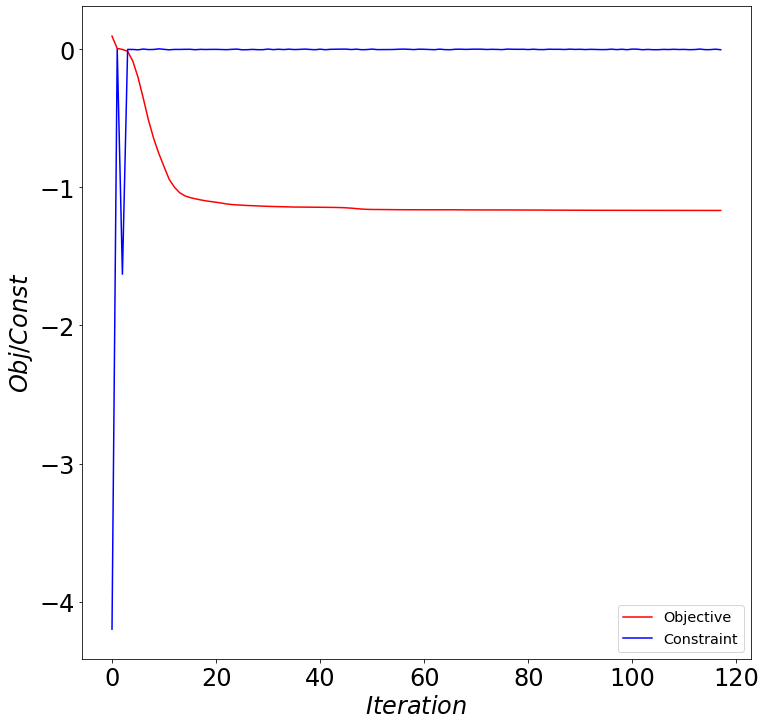

In [181]:
import matplotlib.pyplot as plt

fs = 24
ls = 24
fig, ax = plt.subplots()
its = range(len(objHist))
ax.plot(its, objHist, 'r', label='Objective')
ax.plot(its, constHist, 'b', label='Constraint')
ax.set_xlabel('$Iteration$', fontsize=fs)
ax.set_ylabel('$Obj / Const$', fontsize=fs)
#ax.set_xlim(0,6)
#ax.set_ylim(-20, 200)
ax.tick_params(axis='both', labelsize=ls)
#ax.set_aspect(1)
#ax.set_xticks(np.arange(-2,2.1,1))
#ax.set_yticks(np.arange(-2,2.1,1))
ax.legend(loc='best', fontsize=0.6*fs)

fig.set_size_inches(12, 12)

plt.show()